# Import core libs

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Explore the data

### Get label from csv

In [2]:
data_dir = '/epochs'
steering_csv =[]
for i in range(1,10):
    file = os.path.join(data_dir, "epoch{:0>2}_steering.csv".format(i))
    steering_csv.append(pd.read_csv(file))
steering_csv = pd.concat(steering_csv)
steering_csv.describe()

,frame,frame_index,ts_micro,wheel
count,5400.000000,18900.00000,2.430000e+04,24300.000000
mean,1616.166667,1349.50000,1.464381e+15,-0.173333
std,1120.991308,779.44343,1.437537e+11,4.594643
min,0.000000,0.00000,1.464304e+15,-18.000000
25%,674.750000,674.75000,1.464304e+15,-2.000000
50%,1349.500000,1349.50000,1.464305e+15,0.000000
75%,2549.250000,2024.25000,1.464306e+15,1.500000
max,3899.000000,2699.00000,1.464650e+15,15.000000


In [3]:
def showCount(data,save_path):
    if not os.path.exists('./graphs'):
        os.makedirs('./graphs')
    plt.figure
    plt.hist(data,100);
    plt.xlabel('Steering Angle (deg)')
    plt.ylabel('Counts')
    plt.grid(True)
    plt.savefig(save_path)

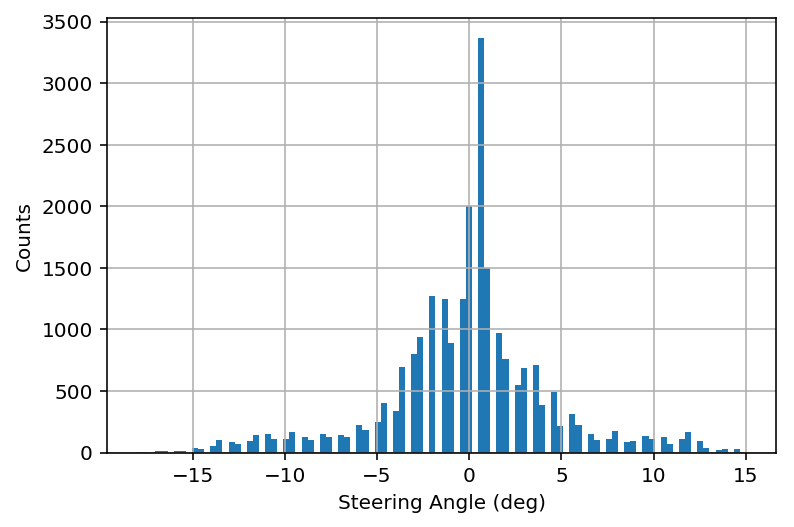

In [4]:
showCount(steering_csv['wheel'],"./graphs/label_distribution.png")

### Get image from video

In [5]:
cap = cv2.VideoCapture('/epochs/epoch01_front.mkv')
ret, frame = cap.read()

#### show image & size

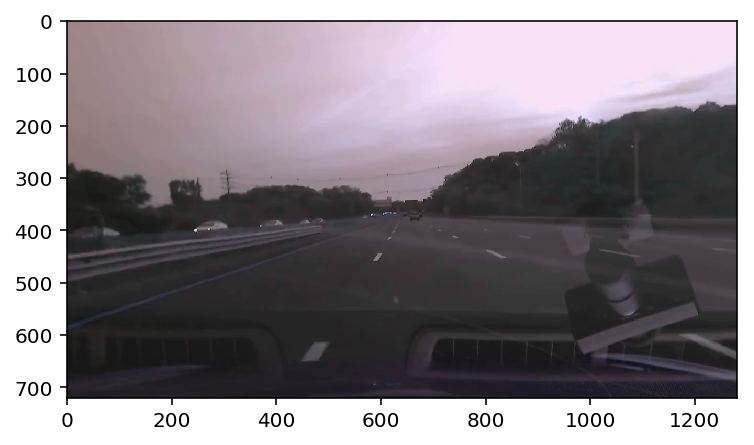

In [6]:
plt.imshow(frame)

In [7]:
print(frame.shape)

(720, 1280, 3)


#### Preprocess data

Crop the center of the primitive image and generate an image of 66x200x3

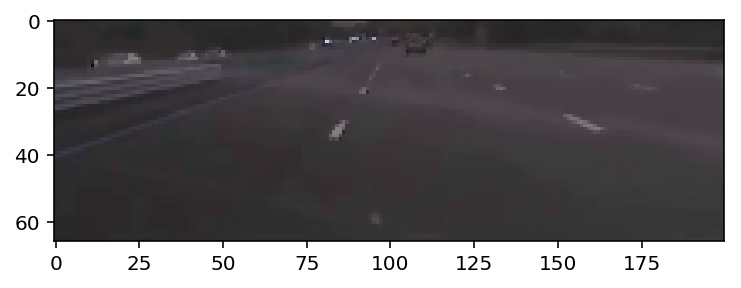

In [8]:
import params
import preprocess
preprocess = preprocess.preprocess
plt.imshow(preprocess(frame))

# Load Data

#### Load labels

In [9]:
labels = steering_csv['wheel']

#### Load features

In [10]:
features = []
for i in range(1,10):
    cap = cv2.VideoCapture('/epochs/epoch{:0>2}_front.mkv'.format(i))
    ret, frame = cap.read()
    while ret:
        features.append(preprocess(frame))
        ret, frame = cap.read()
features = np.array(features)

In [11]:
print(features.shape)

(24300, 66, 200, 3)


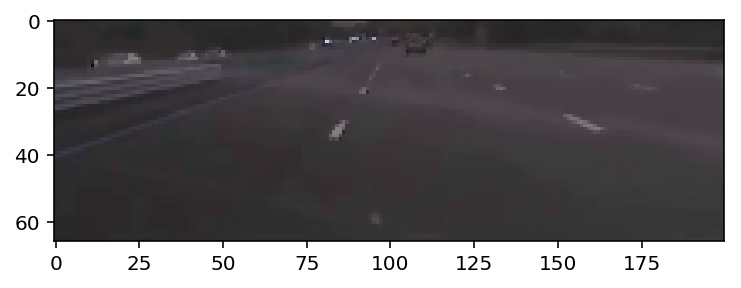

In [12]:
plt.imshow(features[0])

# Form train data and validation data

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
def split_data(x, y, test_size=0.2,shuffle=False):
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=1, shuffle = shuffle)
    return X_train, X_val, y_train, y_val

#### Set shuffled data

In [15]:
X_s_train, X_s_val, y_s_train, y_s_val = train_test_split(features, labels, test_size=0.2, random_state=1)

#### Set unshuffled data

In [16]:
cut = features.shape[0] // 5 * 4
X_train = features[:cut]
y_train = labels[:cut]
X_val = features[cut:]
y_val = labels[cut:]

# Load Test Data

#### Load test labels

In [17]:
y_test = pd.read_csv('/epochs/epoch{}_steering.csv'.format(10))['wheel']

In [18]:
y_test.describe()

count    2700.000000
mean       -1.826667
std         2.128502
min        -6.500000
25%        -3.500000
50%        -2.500000
75%        -0.500000
max         3.500000
Name: wheel, dtype: float64

#### Load test features

In [19]:
X_test = []
cap = cv2.VideoCapture('/epochs/epoch{}_front.mkv'.format(10))
ret, frame = cap.read()
while ret:
    X_test.append(preprocess(frame))
    ret, frame = cap.read()
X_test = np.array(X_test)

In [20]:
X_test.shape

(2700, 66, 200, 3)

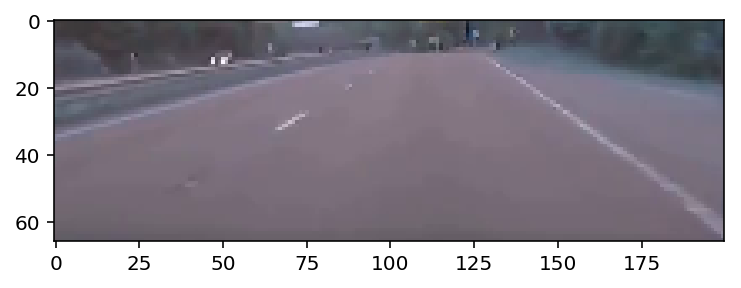

In [21]:
plt.imshow(X_test[0])

# Implementation

In [22]:
import keras
import params
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda, BatchNormalization, Convolution2D, Activation
from keras import initializers
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


## Utils

#### save model architecture

In [23]:
def save_model(model, model_name):
    path = './models'
    if not os.path.exists(path):
        os.makedirs(path)
    model_path = './models/{}.json'.format(model_name)
    json_string = model.to_json()
    with open(model_path, 'w') as outfile:
        outfile.write(json_string)
    print('Model saved')

#### Draw learning curves

In [24]:
def draw_compare_curve(history, history_s, name):
    plt.plot(history.history['loss'], 'C0--')
    plt.plot(history.history['val_loss'], 'C0')

    plt.plot(history_s.history['loss'], 'C1--')
    plt.plot(history_s.history['val_loss'], 'C1')

    # plt.title('model loss')
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['train', 'valid', 'train shuffle', 'valid shuffle'], loc='upper right')
    plt.xlim((0,20))
    plt.xticks(np.arange(0, 21, 2))
    plt.grid()
    plt.savefig("./graphs/{}.png".format(name), dpi=300)
    plt.show()

In [25]:
def draw_curve(history):
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.plot(history.history['loss'], color='r', label='Training Loss')
    ax.plot(history.history['val_loss'], color='g', label='Validation Loss')
    ax.legend(loc='best',shadow=True)
    ax.grid(True)

In [26]:
def draw_test_curve(model, X_test, y_test, name):
    pred_degs = model.predict(X_test,batch_size=X_test.shape[0])
    real_degs = y_test
    
    plt.figure
    plt.plot(pred_degs)
    plt.plot(real_degs)
    plt.ylabel('Steering angle', fontsize=12)
    plt.xlabel('Frame', fontsize=12)
    plt.xlim((0, 2700))
    plt.xticks(np.arange(0, 2701, 300))
    plt.legend(['predicted degree', 'real degree'], loc='upper right')
    plt.grid()
    plt.savefig("./graphs/{}.png".format(name), dpi=300)
    plt.show()

## Set batch size and epoch

In [71]:
batch_size = 512
epochs = 20

##  Benchmark model

Create a benchmark model

In [75]:
def get_benchmark_model():
    input_shape = (params.img_height, params.img_width, params.img_channels)
    # model
    model = Sequential()
    model.add(Conv2D(filters=24, kernel_size=5, strides=2, padding='valid', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=36, kernel_size=5, strides=2, padding='valid', activation='relu'))
    model.add(Conv2D(filters=48, kernel_size=5, strides=2, padding='valid', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=1160, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(units=10, activation='relu'))
    model.add(Dense(units=1))
    adam = optimizers.Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=adam)
    return model

Save benchmark model

In [76]:
save_model(get_benchmark_model(), 'benchmark_model')

Model saved


train and evaluate ordered benchmark model

In [77]:
benchmark_model = get_benchmark_model()
benchmark_history =  benchmark_model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_val, y_val)
                    )
benchmark_model.evaluate(X_test, y_test, batch_size=100)

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 13s - loss: 22.7564 - val_loss: 14.2734
Epoch 2/20
19440/19440 [==============================] - 12s - loss: 22.0712 - val_loss: 14.2413
Epoch 3/20
19440/19440 [==============================] - 12s - loss: 22.8192 - val_loss: 14.2981
Epoch 4/20
19440/19440 [==============================] - 12s - loss: 22.1342 - val_loss: 14.1252
Epoch 5/20
19440/19440 [==============================] - 12s - loss: 21.1225 - val_loss: 14.0123
Epoch 6/20
19440/19440 [==============================] - 12s - loss: 19.6971 - val_loss: 13.7682
Epoch 7/20
19440/19440 [==============================] - 12s - loss: 17.9282 - val_loss: 13.9624
Epoch 8/20
19440/19440 [==============================] - 12s - loss: 16.6155 - val_loss: 13.8910
Epoch 9/20
19440/19440 [==============================] - 12s - loss: 15.4330 - val_loss: 14.0367
Epoch 10/20
19440/19440 [==============================] - 12s - loss

5.2234052309283507

train and evaluate shuffled benchmark model

In [78]:
shuffled_benchmark_model = get_benchmark_model()
shuffled_benchmark_history = shuffled_benchmark_model.fit(X_s_train, 
                    y_s_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_s_val, y_s_val)
                    )
shuffled_benchmark_model.evaluate(X_test, y_test, batch_size=100)

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 13s - loss: 20.8289 - val_loss: 20.9319
Epoch 2/20
19440/19440 [==============================] - 12s - loss: 20.2546 - val_loss: 20.5740
Epoch 3/20
19440/19440 [==============================] - 12s - loss: 19.7209 - val_loss: 19.8623
Epoch 4/20
19440/19440 [==============================] - 12s - loss: 19.1137 - val_loss: 19.5957
Epoch 5/20
19440/19440 [==============================] - 12s - loss: 18.7305 - val_loss: 19.0587
Epoch 6/20
19440/19440 [==============================] - 12s - loss: 17.7308 - val_loss: 17.9850
Epoch 7/20
19440/19440 [==============================] - 12s - loss: 16.4063 - val_loss: 15.9409
Epoch 8/20
19440/19440 [==============================] - 12s - loss: 14.8805 - val_loss: 13.2480
Epoch 9/20
19440/19440 [==============================] - 12s - loss: 13.3134 - val_loss: 12.2720
Epoch 10/20
19440/19440 [==============================] - 12s - loss

3.8371421200809657

show result

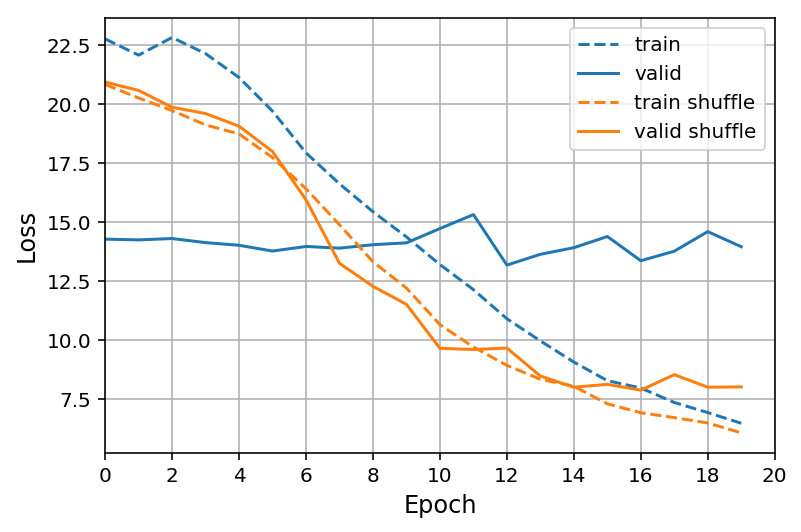

In [79]:
draw_compare_curve(benchmark_history, shuffled_benchmark_history, 'benchmark_model_compare')

## New model

Create a new model

In [84]:
def get_my_model():
    input_shape = (66, 200, 3)
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=24, kernel_size=5, strides=1, padding='valid', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(filters=48, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    adam = optimizers.Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=adam)
    return model

Save this new model

In [85]:
save_model(get_my_model(), 'my_model')

Model saved


train and evaluate ordered benchmark model

In [86]:
my_model = get_benchmark_model()
my_model_history =  my_model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_val, y_val)
                    )
my_model.evaluate(X_test, y_test, batch_size=100)

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 13s - loss: 22.6588 - val_loss: 14.2941
Epoch 2/20
19440/19440 [==============================] - 12s - loss: 22.8411 - val_loss: 14.2801
Epoch 3/20
19440/19440 [==============================] - 12s - loss: 22.8398 - val_loss: 14.2663
Epoch 4/20
19440/19440 [==============================] - 12s - loss: 22.8455 - val_loss: 14.2583
Epoch 5/20
19440/19440 [==============================] - 12s - loss: 22.8321 - val_loss: 14.2563
Epoch 6/20
19440/19440 [==============================] - 12s - loss: 22.5211 - val_loss: 14.1901
Epoch 7/20
19440/19440 [==============================] - 12s - loss: 20.8532 - val_loss: 14.1292
Epoch 8/20
19440/19440 [==============================] - 12s - loss: 19.1316 - val_loss: 14.0009
Epoch 9/20
19440/19440 [==============================] - 12s - loss: 17.5868 - val_loss: 13.8615
Epoch 10/20
19440/19440 [==============================] - 12s - loss

4.0534861893565566

train and evaluate shuffled benchmark model

In [87]:
shuffled_my_model = get_benchmark_model()
shuffled_my_model_history = shuffled_my_model.fit(X_s_train, 
                    y_s_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_s_val, y_s_val)
                    )
shuffled_my_model.evaluate(X_test, y_test, batch_size=100)

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 13s - loss: 21.1170 - val_loss: 20.9606
Epoch 2/20
19440/19440 [==============================] - 12s - loss: 19.8757 - val_loss: 19.9252
Epoch 3/20
19440/19440 [==============================] - 12s - loss: 18.8621 - val_loss: 19.2444
Epoch 4/20
19440/19440 [==============================] - 12s - loss: 18.0054 - val_loss: 16.8736
Epoch 5/20
19440/19440 [==============================] - 12s - loss: 16.7914 - val_loss: 15.8496
Epoch 6/20
19440/19440 [==============================] - 12s - loss: 15.7782 - val_loss: 16.8072
Epoch 7/20
19440/19440 [==============================] - 12s - loss: 15.2279 - val_loss: 15.3516
Epoch 8/20
19440/19440 [==============================] - 12s - loss: 14.0990 - val_loss: 14.8286
Epoch 9/20
19440/19440 [==============================] - 12s - loss: 13.2960 - val_loss: 13.0898
Epoch 10/20
19440/19440 [==============================] - 12s - loss

5.8083085009345305

show result

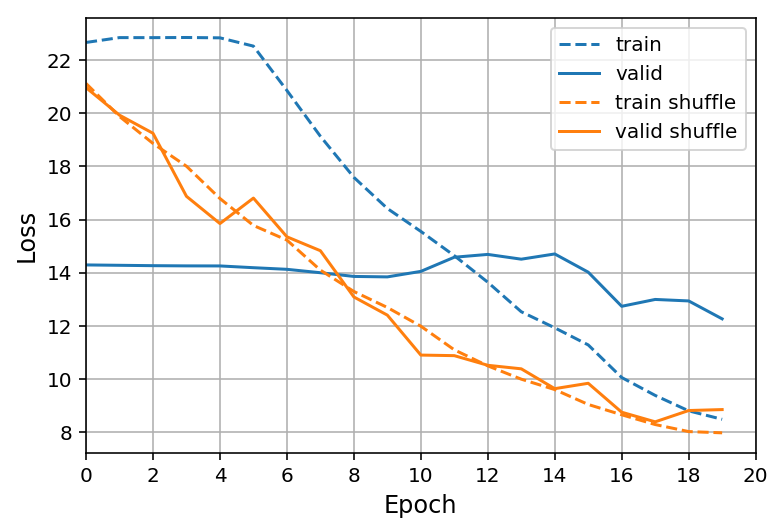

In [88]:
draw_compare_curve(my_model_history, shuffled_my_model_history, 'my_model_compare')

## Refine my model

Refine my new model

In [89]:
def get_my_refined_model():
    input_shape = (66, 200, 3)
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', 
                     kernel_initializer='he_normal',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', 
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(filters=48, kernel_size=3, strides=1, padding='valid', 
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', 
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Conv2D(filters=84, kernel_size=3, strides=1, padding='valid', 
                     kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
#     model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(units=1024, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=512, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=256, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=128, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=32, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=16, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.8))
    model.add(Dense(units=1, kernel_initializer='he_normal'))
    adam = optimizers.Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=adam)
    return model

Save this new model

In [90]:
save_model(get_my_refined_model(), 'my_refined_model')

Model saved


train and evaluate ordered benchmark model

In [91]:
my_refined_model = get_my_refined_model()
my_refined_model_history =  my_refined_model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_val, y_val)
                    )
my_refined_model.evaluate(X_test, y_test, batch_size=100)

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 34s - loss: 17.9207 - val_loss: 11.6792
Epoch 2/20
19440/19440 [==============================] - 29s - loss: 12.0169 - val_loss: 39.2509
Epoch 3/20
19440/19440 [==============================] - 29s - loss: 9.7835 - val_loss: 50.6392
Epoch 4/20
19440/19440 [==============================] - 29s - loss: 8.6154 - val_loss: 30.2481
Epoch 5/20
19440/19440 [==============================] - 29s - loss: 8.0888 - val_loss: 70.1034
Epoch 6/20
19440/19440 [==============================] - 29s - loss: 7.5912 - val_loss: 18.8332
Epoch 7/20
19440/19440 [==============================] - 29s - loss: 7.3853 - val_loss: 15.9550
Epoch 8/20
19440/19440 [==============================] - 29s - loss: 7.3119 - val_loss: 20.1395
Epoch 9/20
19440/19440 [==============================] - 29s - loss: 6.8537 - val_loss: 12.8089
Epoch 10/20
19440/19440 [==============================] - 29s - loss: 6.996

5.3305890935438649

train and evaluate shuffled benchmark model

In [92]:
shuffled_my_refined_model = get_my_refined_model()
shuffled_my_refined_model_history = shuffled_my_refined_model.fit(X_s_train, 
                    y_s_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_s_val, y_s_val)
                    )
shuffled_my_refined_model.evaluate(X_test, y_test, batch_size=100)

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 31s - loss: 18.1405 - val_loss: 19.2623
Epoch 2/20
19440/19440 [==============================] - 29s - loss: 12.3226 - val_loss: 30.8012
Epoch 3/20
19440/19440 [==============================] - 29s - loss: 9.9208 - val_loss: 12.1422
Epoch 4/20
19440/19440 [==============================] - 29s - loss: 8.6238 - val_loss: 25.2365
Epoch 5/20
19440/19440 [==============================] - 29s - loss: 8.1248 - val_loss: 23.0740
Epoch 6/20
19440/19440 [==============================] - 29s - loss: 7.6357 - val_loss: 15.9129
Epoch 7/20
19440/19440 [==============================] - 29s - loss: 7.1509 - val_loss: 7.0105
Epoch 8/20
19440/19440 [==============================] - 29s - loss: 6.9367 - val_loss: 6.3158
Epoch 9/20
19440/19440 [==============================] - 29s - loss: 6.7282 - val_loss: 13.3472
Epoch 10/20
19440/19440 [==============================] - 29s - loss: 6.5713 

1.9313928484916687

show result

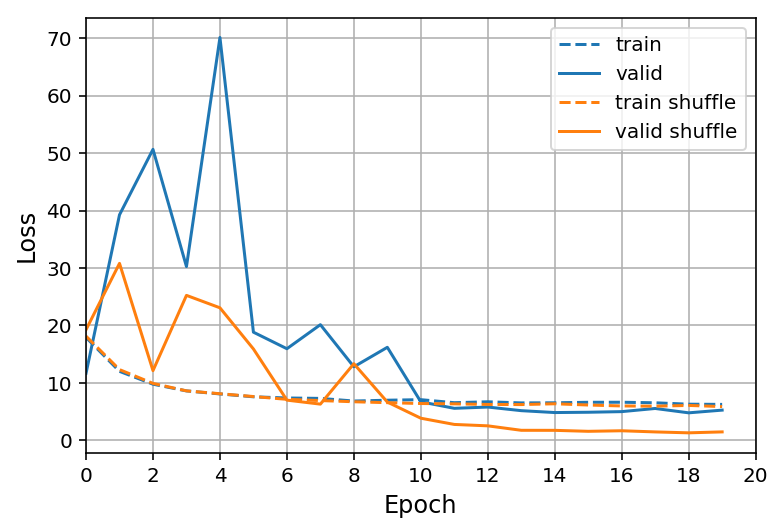

In [93]:
draw_compare_curve(my_refined_model_history, shuffled_my_refined_model_history, 'my_refined_model_compare')

# Show test result

#### Draw test curves

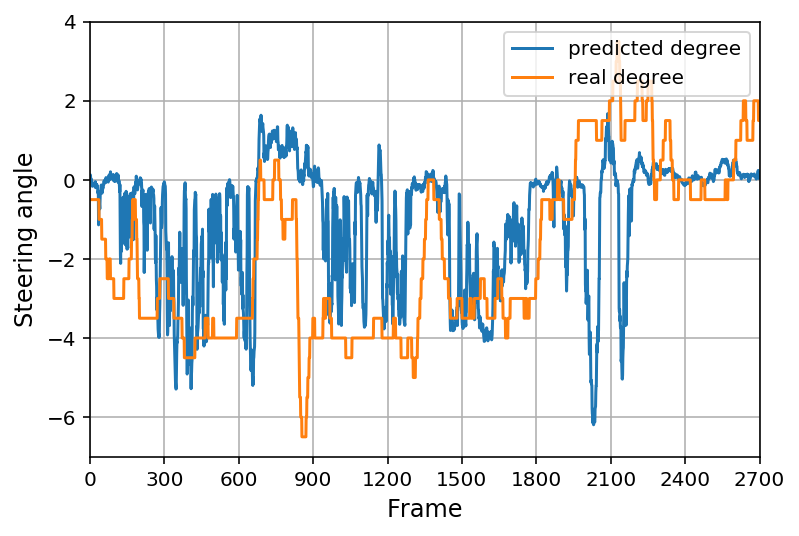

In [94]:
draw_test_curve(benchmark_model, X_test, y_test, 'benchmark_test')

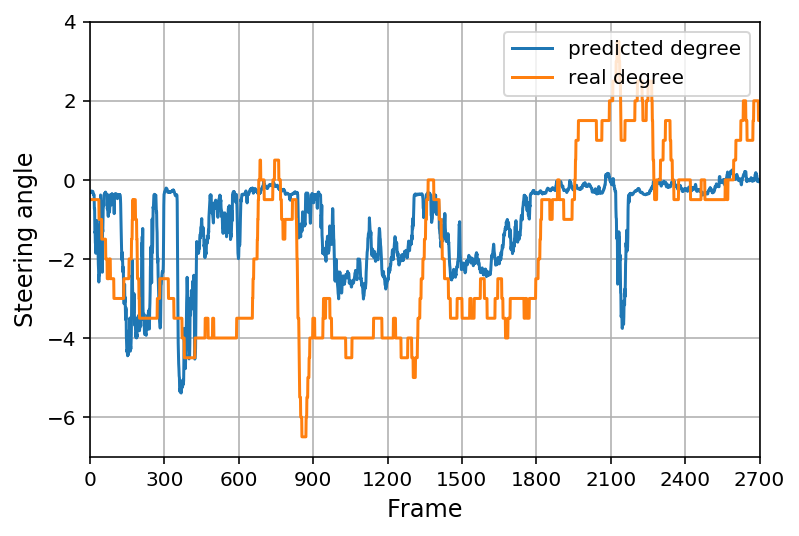

In [95]:
draw_test_curve(shuffled_benchmark_model, X_test, y_test, 'shuffled_benchmark_test')

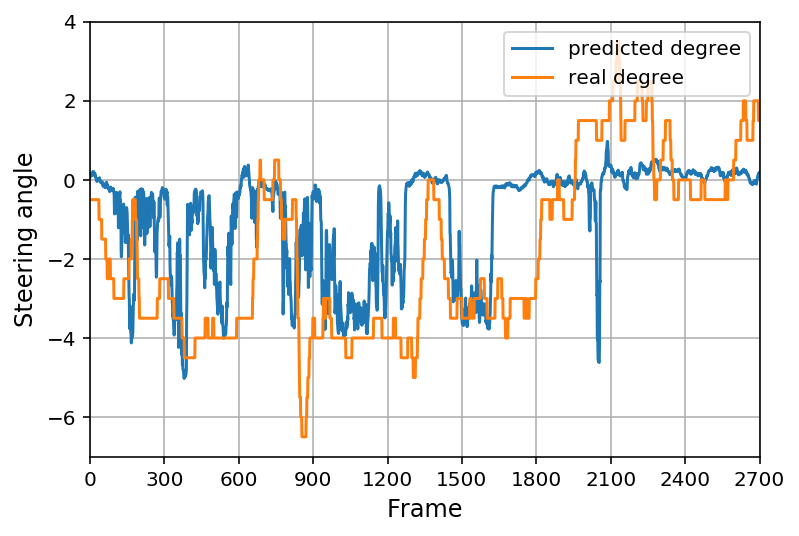

In [96]:
draw_test_curve(my_model, X_test, y_test, 'my_model_test')

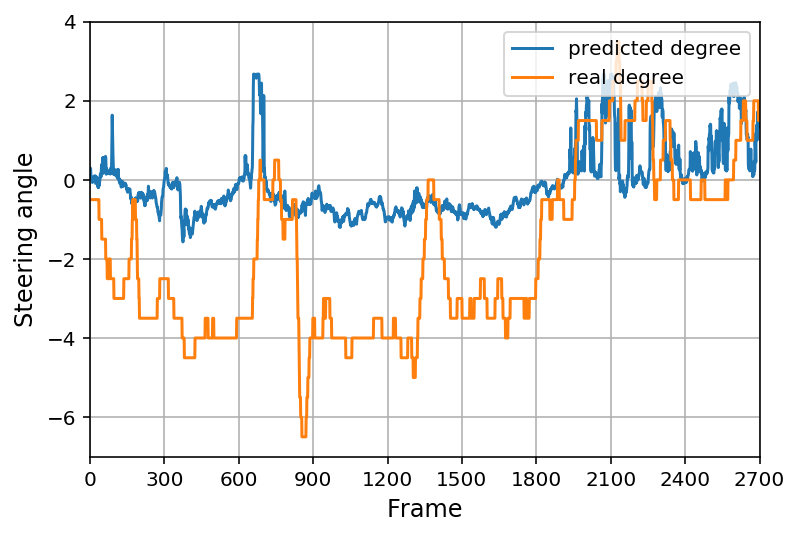

In [97]:
draw_test_curve(shuffled_my_model, X_test, y_test, 'shuffled_my_model_test')

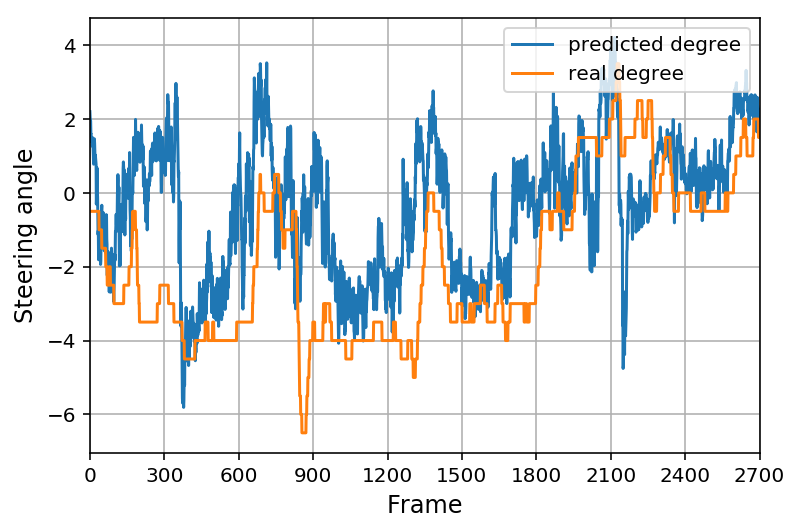

In [98]:
draw_test_curve(my_refined_model, X_test, y_test, 'my_refined_model_test')

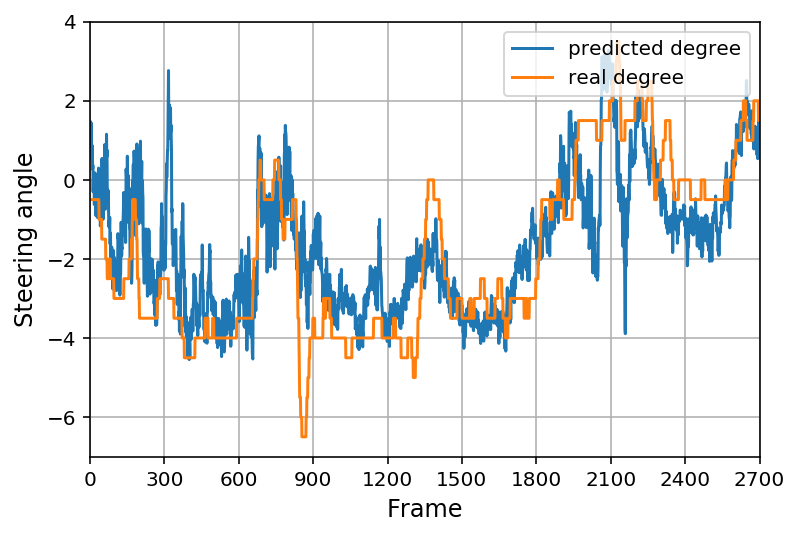

In [99]:
draw_test_curve(shuffled_my_refined_model, X_test, y_test, 'shuffled_my_refined_model_test')

# Save models

In [100]:
model_path = './models'
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [101]:
benchmark_model.save_weights(os.path.join(model_path,'benchmark_model.hdf5'))

In [102]:
shuffled_benchmark_model.save_weights(os.path.join(model_path,'shuffled_benchmark_model.hdf5'))

In [103]:
my_model.save_weights(os.path.join(model_path,'my_model.hdf5'))

In [104]:
shuffled_my_model.save_weights(os.path.join(model_path,'shuffled_my_model.hdf5'))

In [105]:
my_refined_model.save_weights(os.path.join(model_path,'my_refined_model.hdf5'))

In [106]:
shuffled_my_refined_model.save_weights(os.path.join(model_path,'shuffled_my_refined_model.hdf5'))